# Introduction

## About

This notebooks aims to assess scalability of the `rtrgsyl` implementation by selecting the number of threads. 

In order to use this notebook, one should **carefully monitor CPU usage** (with a core-by-core display) in order to check that the desired number of cores are used. 

## Check config

In [3]:
import numpy as np

In [4]:
np.show_config()

blas_mkl_info:
  NOT AVAILABLE
blis_info:
  NOT AVAILABLE
openblas_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
blas_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_mkl_info:
  NOT AVAILABLE
openblas_lapack_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]
lapack_opt_info:
    libraries = ['openblas', 'openblas']
    library_dirs = ['/usr/local/lib']
    language = c
    define_macros = [('HAVE_CBLAS', None)]


This shows that on my computer, OpenBLAS is used (instead of e.g. MKL).

## Control number of threads

There are several ways of doing this. One is to modify the environment variable `OMP_NUM_THREADS` **before importing numpy** (see this github [issue](https://github.com/numpy/numpy/issues/11826)). 

A better solution is to use the [`threadpoolctl` package](https://github.com/joblib/threadpoolctl):

```python
from threadpoolctl import threadpool_limits
import numpy as np


with threadpool_limits(limits=1, user_api='blas'):
    # In this block, calls to blas implementation (like openblas or MKL)
    # will be limited to use only one thread. They can thus be used jointly
    # with thread-parallelism.
    a = np.random.randn(1000, 1000)
    a_squared = a @ a
```

# Benchmark

## Vary number of threads

In [13]:
from benchmark_utils import benchmark
from utils import solve_sylvester_scipy
from recursive import rtrgsyl
from threadpoolctl import threadpool_limits

In [24]:
dimensions = [(500, 500), (1000, 1000), (1500, 1500)]

res_scipy = []
nmax = 6

for n_threads in range(1, nmax+1):
    with threadpool_limits(limits=n_threads):
        res_scipy += benchmark(
            solve_fun=solve_sylvester_scipy, 
            vary_param=('dim', dimensions),
            log_context={'nthreads': n_threads, 'solve_fun': 'syl_scipy', 'bartel_stewart': True},
            bertel_stewart=True
        )

dim=(500, 500)
dim=(1000, 1000)
dim=(1500, 1500)
dim=(500, 500)
dim=(1000, 1000)
dim=(1500, 1500)
dim=(500, 500)
dim=(1000, 1000)
dim=(1500, 1500)
dim=(500, 500)
dim=(1000, 1000)
dim=(1500, 1500)
dim=(500, 500)
dim=(1000, 1000)
dim=(1500, 1500)
dim=(500, 500)
dim=(1000, 1000)
dim=(1500, 1500)


In [26]:
res_rtrgsyl = []
nmax = 6

for n_threads in range(1, nmax+1):
    with threadpool_limits(limits=n_threads):
        res_rtrgsyl += benchmark(
            solve_fun=rtrgsyl, 
            vary_param=('dim', dimensions),
            log_context={'nthreads': n_threads, 'solve_fun': 'rtrgsyl', 'bartel_stewart': True, 'std_solver': 'syl_scipy'},
            bertel_stewart=True,
            blks=64,
            std_solver=solve_sylvester_scipy
        )

dim=(500, 500)
dim=(1000, 1000)
dim=(1500, 1500)
dim=(500, 500)
dim=(1000, 1000)
dim=(1500, 1500)
dim=(500, 500)
dim=(1000, 1000)
dim=(1500, 1500)
dim=(500, 500)
dim=(1000, 1000)
dim=(1500, 1500)
dim=(500, 500)
dim=(1000, 1000)
dim=(1500, 1500)
dim=(500, 500)
dim=(1000, 1000)
dim=(1500, 1500)


In [27]:
import json

res_dump = res_rtrgsyl + res_scipy

with open('res/benchmark_scalability.json', 'w') as f:
    json.dump(res_dump, f)

TODO : check that indeed, threadpool_limit also limits the number of threads used by rtrgsyl, not only by numpy. This is not obious at all, since I guess the library only controls OpenBLAS, which has nothing to do with the core of rtrgsyl. 

In [30]:
import pandas as pd
# Format the results of the benchmark() function
def format_results_bs(res_dic):
    df = pd.DataFrame(res_dic)
    df.time = df.time.apply(np.array)
    df['time_schur'] = df.time.apply(lambda lst: [tpl[0] for tpl in lst])
    df['time_solve'] = df.time.apply(lambda lst: [tpl[1] for tpl in lst])
    df['time_back'] = df.time.apply(lambda lst: [tpl[2] for tpl in lst])
    df.drop(columns='time', inplace=True)

    for e in df.columns:
        if e.startswith('time_'):
            df[f'{e}_mean'] = df[e].apply(np.mean)
            df[f'{e}_std'] = df[e].apply(np.std)
    
    df['m'] = df.dim.apply(lambda e: e[0])
    df['n'] = df.dim.apply(lambda e: e[1])
    
    return df

In [31]:
df_scipy = format_results_bs(res_scipy)
df_scipy.head(2)

,dim,nthreads,solve_fun,bartel_stewart,time_schur,time_solve,time_back,time_schur_mean,time_schur_std,time_solve_mean,time_solve_std,time_back_mean,time_back_std,m,n
0,"(500, 500)",1,syl_scipy,True,"[0.3134932518005371, 0.3050198554992676, 0.300...","[0.2950425148010254, 0.29500722885131836, 0.29...","[0.008426666259765625, 0.008472681045532227, 0...",0.305816,0.004891,0.292593,0.004331,0.008417,0.000037,500,500
1,"(1000, 1000)",1,syl_scipy,True,"[1.6137349605560303, 1.5778565406799316, 1.596...","[2.062563896179199, 2.061414957046509, 2.04187...","[0.06674051284790039, 0.06656503677368164, 0.0...",1.612396,0.023558,2.050016,0.013754,0.066358,0.000508,1000,1000


In [32]:
df_rtrgsyl = format_results_bs(res_rtrgsyl)
df_rtrgsyl.head(2)

,blks,std_solver,dim,nthreads,solve_fun,bartel_stewart,time_schur,time_solve,time_back,time_schur_mean,time_schur_std,time_solve_mean,time_solve_std,time_back_mean,time_back_std,m,n
0,64,syl_scipy,"(500, 500)",1,rtrgsyl,True,"[0.3100392818450928, 0.30375099182128906, 0.30...","[0.10752463340759277, 0.10479569435119629, 0.1...","[0.008689403533935547, 0.008448123931884766, 0...",0.303855,0.003226,0.106134,0.001032,0.008847,0.000368,500,500
1,64,syl_scipy,"(1000, 1000)",1,rtrgsyl,True,"[1.6099679470062256, 1.5896635055541992, 1.557...","[0.431884765625, 0.4375762939453125, 0.4368290...","[0.06462597846984863, 0.0652470588684082, 0.06...",1.591396,0.018378,0.436767,0.002914,0.065163,0.000359,1000,1000


In [36]:
import seaborn as sns

<AxesSubplot:xlabel='nthreads', ylabel='time_solve_mean'>

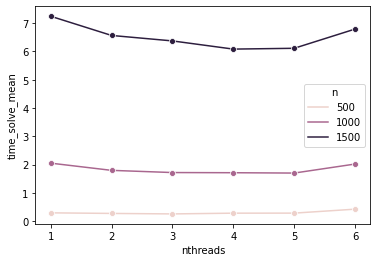

In [46]:
sns.lineplot(x='nthreads', y='time_solve_mean', data=df_scipy, hue='n', marker='o')

<AxesSubplot:xlabel='nthreads', ylabel='time_solve_mean'>

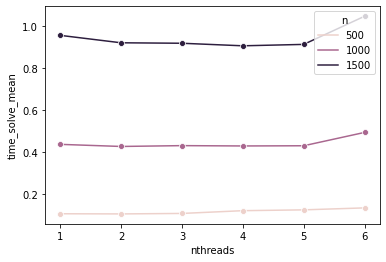

In [47]:
sns.lineplot(x='nthreads', y='time_solve_mean', data=df_rtrgsyl, hue='n', marker='o')

# Produce plots

In [49]:
from ipypublish import nb_setup
plt = nb_setup.setup_matplotlib()
import seaborn as sns
sns.set(style='whitegrid')

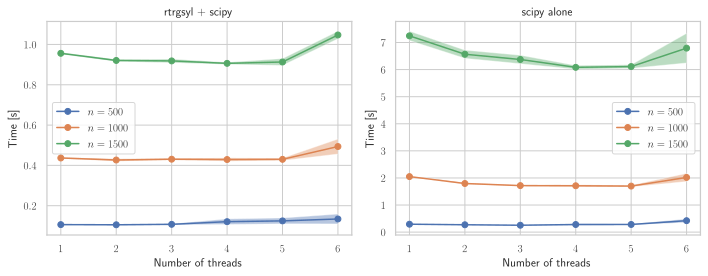

In [60]:
ns = df_rtrgsyl.n.unique()

fig, ax = plt.subplots(1, 2, figsize=(10, 4), sharex=True)

for n in ns:
    sub = df_rtrgsyl[df_rtrgsyl.n == n]
    ax[0].plot(sub.nthreads, sub.time_solve_mean, '-o', label=f'$n={n}$')
    ax[0].fill_between(sub.nthreads, sub.time_solve_mean - sub.time_solve_std, sub.time_solve_mean + sub.time_solve_std, alpha=.4)
    
    sub = df_scipy[df_scipy.n == n]
    ax[1].plot(sub.nthreads, sub.time_solve_mean, '-o', label=f'$n={n}$')
    ax[1].fill_between(sub.nthreads, sub.time_solve_mean - sub.time_solve_std, sub.time_solve_mean + sub.time_solve_std, alpha=.4)
    
ax[0].set_ylabel('Time [s]')
ax[1].set_ylabel('Time [s]')
ax[0].set_xlabel('Number of threads');
ax[1].set_xlabel('Number of threads');
ax[0].set_title('rtrgsyl + scipy')
ax[1].set_title('scipy alone')
ax[0].legend(); ax[1].legend();
plt.tight_layout()
plt.savefig('res/benchmark_scalability.pdf', bbox_inches='tight')